<div class="alert alert-block alert-info">

NOTE: The input matlab (.mat) files were generated using Matlab scripts <p>
which are appended at the bottom of this journal. 

<p>
MD5sums of original input files

</div>

1. 59f161f4efb46a59d31925e7533b548b  regional.grid.a
2. 9307606aa3abced9b96b1d47d8cdb647  regional.grid.b
3. 4cee5a4e9d41097d298c944417656bae  depth_GLBb0.08_11.a
4. 619dc66aa27285ef568ba5b9793db68e  depth_GLBb0.08_11.b



In [ ]:
%pylab inline
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import array
import netCDF4 as nc
from midas.rectgrid import *
import hashlib

In [87]:
f=open('./regional.grid.b')

line1=f.readline()
im=int(line1[0:5])
line2=f.readline()
jm=int(line2[0:5]) - 1
print im,jm
f.close()

4500 3297


In [88]:
dict={}
sio.loadmat('plat.mat',dict)
plat=dict['plat'].T
plat=plat[:-1,:]
dict={}
sio.loadmat('plon.mat',dict)
plon=dict['plon'].T
plon=plon[:-1,:]
dict={}
sio.loadmat('ulat.mat',dict)
ulat=dict['ulat'].T
ulat=ulat[:-1,:]
dict={}
sio.loadmat('ulon.mat',dict)
ulon=dict['ulon'].T
ulon=ulon[:-1,:]
dict={}
sio.loadmat('vlat.mat',dict)
vlat=dict['vlat'].T
vlat=vlat[:-1,:]
dict={}
sio.loadmat('vlon.mat',dict)
vlon=dict['vlon'].T
vlon=vlon[:-1,:]
dict={}
sio.loadmat('qlat.mat',dict)
qlat=dict['qlat'].T
qlat=qlat[:-1,:]
dict={}
sio.loadmat('qlon.mat',dict)
qlon=dict['qlon'].T
qlon=qlon[:-1,:]
dict={}
sio.loadmat('depth.mat',dict)
depth=dict['depth'].T
depth=depth[:-1,:]

In [89]:
print plat.max(),plat.min()
print plon.max(),plon.min()
depth[np.isnan(depth)]=0.0
print depth.max(),depth.min()

89.977722168 -78.6399993896
434.1199646 74.1200256348
7199.97998047 0.0


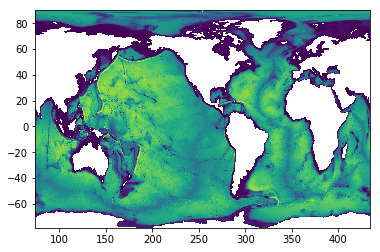

In [90]:
plt.pcolormesh(plon,plat,np.ma.masked_where(depth==0.,depth));

In [91]:
def gen_supergrid(plon,ulon,vlon,qlon,plat,ulat,vlat,qlat):
    lon_offset=0.
    if np.max(plon) > 360: lon_off=360.
    x1=ulon-lon_off; x2=plon-lon_off
    ny,nx=x1.shape
    x1=x1.flatten();x2=x2.flatten()
    X1=np.insert(x2,np.arange(len(x1)),x1)
    X1=np.reshape(X1,(ny,2*nx))
    x1=qlon-lon_off;x2=vlon-lon_off
    x1=x1.flatten();x2=x2.flatten()
    X2=np.insert(x2,np.arange(len(x1)),x1)
    X2=np.reshape(X2,(ny,2*nx))
    X=np.zeros((2*ny+1,2*nx+1))
    X[1::2,0:-1]=X1
    X[1::2,-1]=X[1::2,0]+360.
    X[0:-1:2,1:]=X2
    X[0:-1:2,0]=X[0:-1:2,-1]-360.
    X[0,:]=X[1,:]
    ny,nx=X.shape
    X[-1,0:(nx-1)/4]=X[-1,0]
    X[-1,(nx-1)/4:3*(nx-1)/4]=X[-1,0]+180.
    X[-1,3*(nx-1)/4:]=X[-1,0]+360.
    
    x1=ulat; x2=plat
    ny,nx=x1.shape
    x1=x1.flatten(); x2=x2.flatten()
    X1=np.insert(x2,np.arange(len(x1)),x1)
    X1=np.reshape(X1,(ny,2*nx))
    x1=qlat; x2=vlat
    x1=x1.flatten(); x2=x2.flatten()
    X2=np.insert(x2,np.arange(len(x1)),x1)
    X2=np.reshape(X2,(ny,2*nx))
    Y=np.zeros((2*ny+1,2*nx+1))
    Y[1::2,0:-1]=X1
    Y[0:-1:2,0:-1]=X2
    Y[:,-1]=Y[:,0]
    Y[-1,:]=0.5*(Y[-2,:]+Y[-2,::-1])
    return X,Y
    

In [92]:
X,Y=gen_supergrid(plon,ulon,vlon,qlon,plat,ulat,vlat,qlat)

In [93]:
sgrid=supergrid(xdat=X,ydat=Y,cyclic_x=True,axis_units='degrees')

In [94]:
def angle_p1p2(p1, p2):
    """Angle at center of sphere between two points on the surface of the sphere.
    Positions are given as (latitude,longitude) tuples measured in degrees."""
    phi1 = numpy.deg2rad( p1[0] )
    phi2 = numpy.deg2rad( p2[0] )
    dphi_2 = 0.5 * ( phi2 - phi1 )
    dlambda_2 = 0.5 * numpy.deg2rad( p2[1] - p1[1] )
    a = numpy.sin( dphi_2 )**2 + numpy.cos( phi1 ) * numpy.cos( phi2 ) * ( numpy.sin( dlambda_2 )**2 )
    c = 2. * numpy.arctan2( numpy.sqrt(a), numpy.sqrt( 1. - a ) )
    return c


def spherical_angle(v1, v2, v3):
    """Returns angle v2-v1-v3 i.e betweeen v1-v2 and v1-v3."""
    # vector product between v1 and v2
    px = v1[1]*v2[2] - v1[2]*v2[1]
    py = v1[2]*v2[0] - v1[0]*v2[2]
    pz = v1[0]*v2[1] - v1[1]*v2[0]
    # vector product between v1 and v3
    qx = v1[1]*v3[2] - v1[2]*v3[1]
    qy = v1[2]*v3[0] - v1[0]*v3[2]
    qz = v1[0]*v3[1] - v1[1]*v3[0]

    ddd = (px*px+py*py+pz*pz)*(qx*qx+qy*qy+qz*qz)
    ddd = (px*qx+py*qy+pz*qz) / numpy.sqrt(ddd)
    angle = numpy.arccos( ddd );
    return angle

def spherical_quad(lat,lon):
    """Returns area of spherical quad (bounded by great arcs)."""
    # x,y,z are 3D coordinates
    d2r = numpy.deg2rad(1.)
    x = numpy.cos(d2r*lat)*numpy.cos(d2r*lon)
    y = numpy.cos(d2r*lat)*numpy.sin(d2r*lon)
    z = numpy.sin(d2r*lat)
    c0 = (x[:-1,:-1],y[:-1,:-1],z[:-1,:-1])
    c1 = (x[:-1,1:],y[:-1,1:],z[:-1,1:])
    c2 = (x[1:,1:],y[1:,1:],z[1:,1:])
    c3 = (x[1:,:-1],y[1:,:-1],z[1:,:-1])
    a0 = spherical_angle( c1, c0, c2)
    a1 = spherical_angle( c2, c1, c3)
    a2 = spherical_angle( c3, c2, c0)
    a3 = spherical_angle( c0, c3, c1)
    return a0+a1+a2+a3-2.*numpy.pi


In [ ]:
snj,sni = sgrid.x.shape
snj=snj-1;sni=sni-1
sgrid.area = np.zeros((snj,sni))
sgrid.dx = np.zeros((snj+1,sni))
sgrid.dy = np.zeros((snj,sni+1))
sgrid.angle_dx = np.zeros((snj+1,sni+1))

# Approximate edge lengths as great arcs
R = 6370.e3 # Radius of sphere
sgrid.dx = R*angle_p1p2( (sgrid.y[:,1:],sgrid.x[:,1:]), (sgrid.y[:,:-1],sgrid.x[:,:-1]) )
sgrid.dy = R*angle_p1p2( (sgrid.y[1:,:],sgrid.x[1:,:]), (sgrid.y[:-1,:],sgrid.x[:-1,:]) )

# Approximate angles using centered differences in interior
sgrid.angle_dx[:,1:-1] = np.arctan( (sgrid.y[:,2:]-sgrid.y[:,:-2]) / \
                       ((sgrid.x[:,2:]-sgrid.x[:,:-2])*np.cos(np.deg2rad(sgrid.y[:,1:-1]))) )
# Approximate angles using side differences on left/right edges
sgrid.angle_dx[:,0] = np.arctan( (sgrid.y[:,1]-sgrid.y[:,0]) / ((sgrid.x[:,1]-sgrid.x[:,0])*\
                                    np.cos(np.deg2rad(sgrid.y[:,0]))) )
sgrid.angle_dx[:,-1] = np.arctan( (sgrid.y[:,-1]-sgrid.y[:,-2]) / ((sgrid.x[:,-1]-sgrid.x[:,-2])*\
                                                                np.cos(np.deg2rad(sgrid.y[:,-1]))) )

# Approximate cell areas as that of spherical polygon
sgrid.area = R*R*spherical_quad(sgrid.y,sgrid.x)

bad=np.where(np.isnan(sgrid.angle_dx))
print bad
sgrid.angle_dx[np.isnan(sgrid.angle_dx)]=0.0

In [96]:
sgrid.angle_dx = sgrid.angle_dx * 180./np.pi

In [97]:
sgrid.have_metrics=True
sgrid.write_nc('ocean_hgrid.nc',format='NETCDF4_CLASSIC')

In [107]:
def ice9it(i,j,depth,shallow=0.0):
  # Iterative implementation of "ice 9"
  wetMask = 0*depth
  (nj,ni) = wetMask.shape
  stack = set()
  stack.add( (j,i) )
  while stack:
    (j,i) = stack.pop()
#    print i,j,depth[j,i]
    if wetMask[j,i] or depth[j,i] <= shallow: continue
    wetMask[j,i] = 1
    if i>0: stack.add( (j,i-1) )
    else: stack.add( (j,ni-1) )
    if i<ni-1: stack.add( (j,i+1) )
    else: stack.add( (0,j) )
    if j>0: stack.add( (j-1,i) )
    if j<nj-1: stack.add( (j+1,i) )
    else: stack.add( (j,ni-1-i) )
  return wetMask

def error(note):
    print note
    
def save_topo(depth, wet=None, fileName=None):


  rg=nc.Dataset( fileName, 'w', format='NETCDF3_CLASSIC' )
  
  (ny, nx) = depth.shape
  rg.createDimension('nx',nx)
  rg.createDimension('ny',ny)
  rgDepth = rg.createVariable('depth','f4',('ny','nx'))
  rgDepth.units = 'm'
  rgDepth.standard_name = 'topographic depth at T-cell centers'
  rg.createDimension('ntiles',1)
  rgWet = rg.createVariable('wet','f4',('ny','nx'))
  rgWet.long_name = 'Wet/dry mask'
  rgWet.description = 'Values: 1=Ocean, 0=Land'
  if wet is None:
    wet=np.zeros(depth.shape)
    wet[depth>0.]=1.0
  rgWet[:] = wet 
  rgDepth[:] = depth*wet
  rg.close()
  print 'File "%s" written.'%(fileName)

def applyIce9(depth, shallow=0.0,seedDepth=3000.0):

  res=np.argwhere(depth>seedDepth)
  j0,i0= res[0][0],res[0][1]
  notLand = ice9it(i0,j0,depth)
  print 'Analyzing...'
  numNotLand = np.count_nonzero(notLand)
  print '# of wet points after Ice 9 = %i'%(numNotLand)
  newDepth = depth*np.where(depth*notLand >= shallow, 1, 0)
  numNewWet = np.count_nonzero(newDepth)
  print '# of wet points deeper than %f = %i'%(shallow,numNewWet)
  print '%i - %i = %i fewer points left'%(numNotLand,numNewWet,numNotLand-numNewWet)
  newWet = ice9it(i0,j0,newDepth)
  numNewDeep = np.count_nonzero(newWet)
  print '# of wet deep points after Ice 9 = %i'%(numNewDeep)
  print '%i - %i = %i fewer points left'%(numNewWet,numNewDeep,numNewWet-numNewDeep)
  return newDepth
  





In [99]:
grid=quadmesh(supergrid=sgrid)
grid.D=depth
print depth.min(),depth.max()

0.0 7199.97998047


In [101]:
newDepth=applyIce9(grid.D,shallow=0.0)

Analyzing...
# of wet points after Ice 9 = 8954556
# of wet points deeper than 0.000000 = 8954556
8954556 - 8954556 = 0 fewer points left
# of wet deep points after Ice 9 = 8954556
8954556 - 8954556 = 0 fewer points left


In [108]:
save_topo(grid.D,fileName='topog.nc')

File "topog.nc" written.


In [126]:
h1=hashlib.md5(grid.x_T_bounds.copy(order='C'))
h2=hashlib.md5(grid.y_T_bounds.copy(order='C'))
h3=hashlib.md5(grid.D)

for h in [h1,h2,h3]:
    print h.hexdigest()
    

57dfb765a6ec8d9cd30c7dd015712d6b
18483f049b47487103edf1e46a6aa431
94ba58c0b2e448ccd2509cb83b95b7cd
